In [1]:
spark

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as plt
import io
from google.cloud import storage

In [3]:
from pyspark.sql.functions import col, isnan, isnull, when, count, udf, size, split, year, month, format_number, date_format, length
from pyspark.sql.types import IntegerType, DateType, StringType, StructType, DoubleType
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder, Normalizer, MinMaxScaler, StandardScaler, HashingTF, IDF, Tokenizer, RegexTokenizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import DataFrame
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.ml.stat import Correlation

In [4]:
def read_data(): 
    ## Read Data
    # Read in all files in the cleaned folder
    sdf = spark.read.parquet("gs://my-project-bucket-flights-cl/cleaned/")

    # Take a small sample for demonstration purposes
    #sdf = sdf.sample(withReplacement=False, fraction=0.10, seed=42)

    # Check the schema
    print(sdf.printSchema())

    # Get the number of records in the dataframe
    print("# columns and rows")
    print(len(sdf.columns))
    print(sdf.count())

    return sdf

In [5]:
def clean_data(sdf):
    print("Raw count (before dropna):", sdf.count())
    sdf.limit(5).show()
    
    sdf = sdf.drop("DivAirportLandings")
    
    # Check to see records where ArrDel15 are null
    print(sdf.select([count(when(col(c).isNull(), c)).alias(c) for c in ["ArrDel15"]] ).show())
    # drop null values in data
    #null_counts = sdf.select([
    #    count(when(col(c).isNull(), 1)).alias(c) for c in sdf.columns
    #])
    #null_counts.show()
    sdf = sdf.dropna()
    print(sdf.count())
    
    # Cast ArrDel15 and DepDel15 to integers
    sdf = sdf.withColumn("ArrDel15", col("ArrDel15").cast("int"))
    sdf = sdf.withColumn("DepDel15", col("DepDel15").cast("int"))

    # Show the distribution of ArrDel15 and DepDel15 after transformation
    print("ArrDel15 distribution:")
    sdf.select("ArrDel15").groupby("ArrDel15").count().show()

    print("DepDel15 distribution:")
    sdf.select("DepDel15").groupby("DepDel15").count().show()

    return sdf

In [6]:
# Define bucket and folder as constants
BUCKET_NAME = "my-project-bucket-flights-cl"  
FIGURE_FOLDER = 'figures'

def save_plot_to_gcs(sdf, column_name, file_name):
    """
    Function to plot the frequency distribution of a column and save the plot to Google Cloud Storage.
    
    """
    # Get the frequency counts of the column
    column_counts_df = sdf.groupby(column_name).count().sort(column_name).toPandas()

    # Set up a Matplotlib figure
    fig = plt.figure(facecolor='white')

    # Create a bar plot for the column frequency distribution
    plt.bar(column_counts_df[column_name], column_counts_df['count'])

    # Add a title
    plt.title(f"Count by {column_name}")

    # Add labels for clarity
    plt.xlabel(column_name)
    plt.ylabel('Count')

    plt.show()

    # Create a buffer to hold the figure
    #img_data = io.BytesIO()

    # Write the figure to the img_data buffer
    #fig.savefig(img_data, format='png', bbox_inches='tight')

    # Rewind the pointer to the start of the data
    #img_data.seek(0)

    # Connect to Google Cloud Storage
    #storage_client = storage.Client()

    # Point to the bucket on Google Cloud Storage
    #bucket = storage_client.get_bucket(BUCKET_NAME)

    # Create a blob to hold the data. Use the specific folder and file name format
    #blob = bucket.blob(f"{FIGURE_FOLDER}/order_count_by_{column_name}.png")

    # Upload the img_data contents to the blob
    #blob.upload_from_file(img_data)

    #print(f"Plot saved to Google Cloud Storage at {FIGURE_FOLDER}/order_count_by_{column_name}.png")

In [7]:

def add_time_of_day_column(df: DataFrame, time_col: str, new_col_name: str) -> DataFrame:
    """
    Adds a new time-of-day label column based on the hour extracted from a HHMM-format time column.

    """
    
    # Extract hour from HHMM format (e.g., 1345 → 13)
    df = df.withColumn(f"{time_col}_Hour", (col(time_col) / 100).cast("int"))
    
    # Add time-of-day label column
    # 1 Morning, 2 Afternoon, 3 Evening, 4 Night
    df = df.withColumn(new_col_name, 
        when((col(f"{time_col}_Hour") >= 5) & (col(f"{time_col}_Hour") < 12), 1)
        .when((col(f"{time_col}_Hour") >= 12) & (col(f"{time_col}_Hour") < 17), 2)
        .when((col(f"{time_col}_Hour") >= 17) & (col(f"{time_col}_Hour") < 21), 3)
        .otherwise(4)
    )
    
    # Drop temporary hour column
    df = df.drop(f"{time_col}_Hour")

    return df

In [8]:
def plot_corr_matrix(sdf):
    # Create Correlation Matrix for continuous variables
    continuous_columns = ["CRSElapsedTime", "DepDelayMinutes", "Distance"]
    vector_column = "correlation_features"
    assembler = VectorAssembler(inputCols=continuous_columns, outputCol=vector_column)
    sdf_vector = assembler.transform(sdf).select(vector_column)

    # Create the correlation matrix, then get just the values and convert to a list
    matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]

    # Create the correlation matrix, then get just the values and convert to a list
    matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
    correlation_matrix = matrix.toArray().tolist() 
    # Convert the correlation to a Pandas dataframe
    correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=continuous_columns, index=continuous_columns) 

    heatmap_plot = plt.figure(figsize=(16,5))  
    # Set the style for Seaborn plots
    sns.set_style("white")

    sns.heatmap(correlation_matrix_df, 
                xticklabels=correlation_matrix_df.columns.values,
                yticklabels=correlation_matrix_df.columns.values,  cmap="Greens", annot=True)
    plt.savefig("correlation_matrix.png")


In [9]:
def concat_yearly_data(years):
    # Read the data for each year and store the results in a list
    yearly_dfs = [read_data(year) for year in years]

    # Concatenate the DataFrames for all years
    # We use reduce to iteratively union all DataFrames in the list
    concatenated_df = reduce(lambda df1, df2: df1.unionByName(df2), yearly_dfs)

    # Show the result of the concatenation
    concatenated_df.printSchema()
    
    plot_corr_matrix(concatenated_df)

    return concatenated_df

In [10]:
def add_features(sdf):
    
    ## Feature Engineering 
    # Add time-of-day columns
    time_columns = [
        ("CRSArrTime", "ScheduledArrTimeOfDay"),
        ("CRSDepTime", "ScheduledDepTimeOfDay")]

    for time_col, new_col_name in time_columns:
        sdf = add_time_of_day_column(sdf, time_col, new_col_name)

    # Drop the original time columns after they've been transformed
    time_col_names = [time_col for time_col, _ in time_columns]
    sdf = sdf.drop(*time_col_names)
    
    # Check the distribution of the derived columns to make sure it is evenly balanced (approximately)
    print("ScheduledArrTimeOfDay distribution:")
    sdf.groupBy("ScheduledArrTimeOfDay").count().show()
    save_plot_to_gcs(sdf, "ScheduledArrTimeOfDay", "distribution_schedArr.png")
    
    # Check the distribution of the derived columns to make sure it is evenly balanced (approximately)
    print("ScheduledDepTimeOfDay distribution:")
    sdf.groupBy("ScheduledDepTimeOfDay").count().show()
    save_plot_to_gcs(sdf, "ScheduledDepTimeOfDay", "distribution_schedDep.png")
    
    # drop uneeded columns
    columns_to_drop = ["CRSArrTime", "CRSDepTime", "FlightDate", "Airline", "Cancelled", "Diverted",
                       "Origin", "OriginState", "Dest", "DestState",
                       "DepartureDelayGroups", "DepTimeBlk", "ArrivalDelayGroups",
                       "ArrTimeBlk", "DepTime", "DepDelay", "ArrTime",
                       "ArrDelayMinutes", "AirTime", "ActualElapsedTime", "TaxiOut",
                       "WheelsOff", "WheelsOn", "TaxiIn", "ArrDelay", "DivAirportLandings"]
    sdf = sdf.drop(*columns_to_drop)
       
    # Get some statistics on each of the columns
    # IMPORTANT: This will take a VERY long time to complete
    # sdf.summary().show()
    
    return sdf

In [11]:
def process_data(sdf):

    # Clean data
    sdf_cleaned = clean_data(sdf)

    # Add feature columns (time-of-day columns for scheduled times)
    sdf_features = add_features(sdf_cleaned)

    # Define column names for the processing
    # Categorical columns
    categorical_columns = ["Quarter", "DayOfWeek", "Month", "DayofMonth", "Operating_Airline", "OriginAirportID",
                           "OriginCityName", "OriginStateName", "DestAirportID", "DestCityName", "DestStateName", 
                           "DistanceGroup", "ScheduledArrTimeOfDay", "ScheduledDepTimeOfDay"]

    string_columns = ["Operating_Airline", "OriginAirportID", "OriginCityName", "OriginStateName",
                      "DestAirportID", "DestCityName", "DestStateName", "DistanceGroup"]

    other_categorical_columns = ["Quarter", "DayOfWeek", "Month", "DayofMonth", "DepDel15", "ScheduledArrTimeOfDay", "ScheduledDepTimeOfDay"]

    # Index columns
    index_output_columns = ["Operating_AirlineIndex", "OriginAirportIDIndex", "OriginCityNameIndex", "OriginStateNameIndex", 
                            "DestAirportIDIndex", "DestCityNameIndex", "DestStateNameIndex", "DistanceGroupIndex"]

    # One-hot encoding input and output columns
    ohe_input_columns = index_output_columns + other_categorical_columns
    ohe_output_columns = ["QuarterVector", "DayOfWeekVector", "MonthVector", "DayofMonthVector", 
                          "Operating_AirlineVector", "OriginAirportIDVector", "OriginCityNameVector", "OriginStateNameVector", 
                          "DestAirportIDVector", "DestCityNameVector", "DestStateNameVector", "DepDel15Vector", 
                          "DistanceGroupVector", "ScheduledArrTimeOfDayVector", "ScheduledDepTimeOfDayVector"]

    # Continuous columns
    continuous_columns = ["CRSElapsedTime", "DepDelayMinutes", "Distance", "Year"]
    scaled_columns = ["CRSElapsedTimeScaled", "DepDelayMinutesScaled", "DistanceScaled", "YearScaled"]

    # Create the indexer for string-based columns
    indexer = StringIndexer(inputCols=string_columns, outputCols=index_output_columns, handleInvalid="keep")

    # Create the encoder for the indexed string columns and other categorical columns
    encoder = OneHotEncoder(inputCols=ohe_input_columns, outputCols=ohe_output_columns, dropLast=True, handleInvalid="keep")

    # Create an assembler for continuous columns
    assembler = [VectorAssembler(inputCols=[col], outputCol=col + "Vector") for col in continuous_columns]

    # Create a scaler for continuous columns (use the corresponding Vector column)
    scaler = [MinMaxScaler(inputCol=col + "Vector", outputCol=scaled_col) for col, scaled_col in zip(continuous_columns, scaled_columns)]

    # Final assembler 
    final_assembler = VectorAssembler(inputCols=ohe_output_columns + scaled_columns, outputCol="features")
    
    # Create pipeline
    stages = [indexer, encoder] + assembler + scaler + [final_assembler]
    pipeline = Pipeline(stages=stages)

    # Fit and transform the data
    sdf_transformed = pipeline.fit(sdf_features).transform(sdf_features)
    columns_to_drop = [
        "Quarter", "DayOfWeek", "Month", "DayofMonth", "Operating_Airline", 
        "OriginAirportID", "OriginCityName", "OriginStateName", 
        "DestAirportID", "DestCityName", "DestStateName", "DepDel15",
        "DistanceGroup", "ScheduledArrTimeOfDay", "ScheduledDepTimeOfDay",
        "Operating_AirlineIndex", "OriginAirportIDIndex", "OriginCityNameIndex", 
        "OriginStateNameIndex", "DestAirportIDIndex", "DestCityNameIndex", 
        "DestStateNameIndex", "DistanceGroupIndex", 
        "CRSElapsedTime", "DepDelayMinutes", "Distance", "Year"]
    sdf_transformed_clean = sdf_transformed.drop(*columns_to_drop)

    return sdf_transformed_clean


In [12]:
sdf = spark.read.parquet("gs://my-project-bucket-flights-cl/cleaned/")
print(sdf.printSchema())
# Get the number of records in the dataframe
print("# columns and rows")
print(len(sdf.columns))
print(sdf.count())


root
 |-- FlightDate: timestamp_ntz (nullable = true)
 |-- Airline: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Cancelled: boolean (nullable = true)
 |-- Diverted: boolean (nullable = true)
 |-- Year: long (nullable = true)
 |-- Quarter: long (nullable = true)
 |-- Month: long (nullable = true)
 |-- DayofMonth: long (nullable = true)
 |-- DayOfWeek: long (nullable = true)
 |-- Operating_Airline: string (nullable = true)
 |-- OriginAirportID: string (nullable = true)
 |-- OriginCityName: string (nullable = true)
 |-- OriginState: string (nullable = true)
 |-- OriginStateName: string (nullable = true)
 |-- DestAirportID: string (nullable = true)
 |-- DestCityName: string (nullable = true)
 |-- DestState: string (nullable = true)
 |-- DestStateName: string (nullable = true)
 |-- DepDel15: boolean (nullable = true)
 |-- DepartureDelayGroups: double (nullable = true)
 |-- DepTimeBlk: string (nullable = true)
 |-- ArrivalDelayGroups

28339509


25/04/15 19:53:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Raw count (before dropna): 28339509


+-------------------+-----------------+------+----+---------+--------+----+-------+-----+----------+---------+-----------------+---------------+--------------+-----------+---------------+-------------+------------+---------+-------------+--------+--------------------+----------+------------------+----------+--------+-------------+----------+-------+---------------+--------+-------+---------------+-------+--------------+-----------------+--------+-------+---------+--------+------+----------+--------+------------------+
|         FlightDate|          Airline|Origin|Dest|Cancelled|Diverted|Year|Quarter|Month|DayofMonth|DayOfWeek|Operating_Airline|OriginAirportID|OriginCityName|OriginState|OriginStateName|DestAirportID|DestCityName|DestState|DestStateName|DepDel15|DepartureDelayGroups|DepTimeBlk|ArrivalDelayGroups|ArrTimeBlk|ArrDel15|DistanceGroup|CRSDepTime|DepTime|DepDelayMinutes|DepDelay|ArrTime|ArrDelayMinutes|AirTime|CRSElapsedTime|ActualElapsedTime|Distance|TaxiOut|WheelsOff|WheelsOn

+--------+
|ArrDel15|
+--------+
|       0|
+--------+

None


28339509
ArrDel15 distribution:


+--------+--------+
|ArrDel15|   count|
+--------+--------+
|       1| 5005251|
|       0|23334258|
+--------+--------+

DepDel15 distribution:


+--------+--------+
|DepDel15|   count|
+--------+--------+
|       1| 4881267|
|       0|23458242|
+--------+--------+

ScheduledArrTimeOfDay distribution:


+---------------------+-------+
|ScheduledArrTimeOfDay|  count|
+---------------------+-------+
|                    1|8101266|
|                    3|6829209|
|                    4|4674030|
|                    2|8735004|
+---------------------+-------+



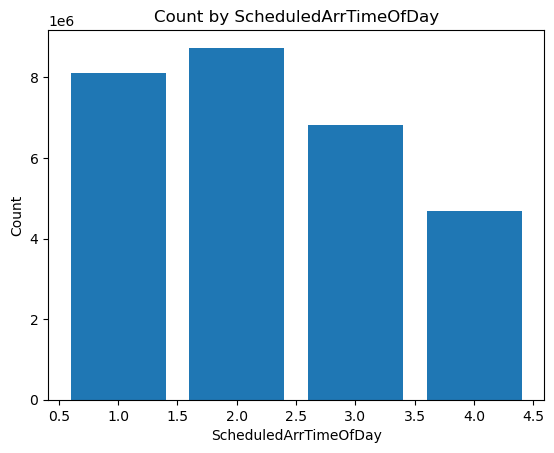

ScheduledDepTimeOfDay distribution:


+---------------------+--------+
|ScheduledDepTimeOfDay|   count|
+---------------------+--------+
|                    1|11765218|
|                    3| 6292181|
|                    4| 1754963|
|                    2| 8527147|
+---------------------+--------+



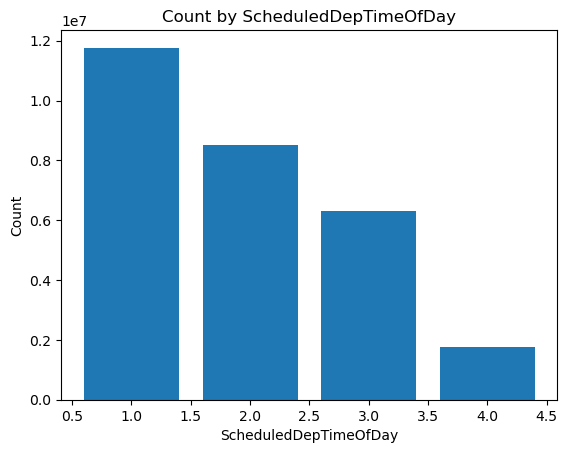

In [13]:
transformed_sdf = process_data(sdf)


In [14]:
print("All Transformed Data Schema: ")
transformed_sdf.printSchema()
transformed_sdf.select('ArrDel15','features').show(30, truncate=False)

All Transformed Data Schema: 
root
 |-- ArrDel15: integer (nullable = true)
 |-- QuarterVector: vector (nullable = true)
 |-- DayOfWeekVector: vector (nullable = true)
 |-- MonthVector: vector (nullable = true)
 |-- DayofMonthVector: vector (nullable = true)
 |-- Operating_AirlineVector: vector (nullable = true)
 |-- OriginAirportIDVector: vector (nullable = true)
 |-- OriginCityNameVector: vector (nullable = true)
 |-- OriginStateNameVector: vector (nullable = true)
 |-- DestAirportIDVector: vector (nullable = true)
 |-- DestCityNameVector: vector (nullable = true)
 |-- DestStateNameVector: vector (nullable = true)
 |-- DepDel15Vector: vector (nullable = true)
 |-- DistanceGroupVector: vector (nullable = true)
 |-- ScheduledArrTimeOfDayVector: vector (nullable = true)
 |-- ScheduledDepTimeOfDayVector: vector (nullable = true)
 |-- CRSElapsedTimeVector: vector (nullable = true)
 |-- DepDelayMinutesVector: vector (nullable = true)
 |-- DistanceVector: vector (nullable = true)
 |-- YearV

+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ArrDel15|features                                                                                                                                                                                                               |
+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0       |(1765,[8,300,683,804,854,1244,1629,1682,1692,1698,1705,1740,1749,1753,1758,1761,1763],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1827568404749613,0.020058793014006572])                           |
|0       |(1765,[8,300,683,804,854,1244,1629,1682,1692,1699,1705,1741,1749,1753,1758,1761,17

Build Model
1. Logistic Regression


In [15]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
from pyspark.ml.linalg import VectorUDT

In [16]:
# Pipeline Example: Model Specification

# Optional: Take a small sample of the data while developing the rest of the code
# transformed_sdf = transformed_sdf.sample(False, .25)

# Split the data into 70% training and 30% test sets  
trainingData, testData = transformed_sdf.randomSplit([0.7, 0.3], seed=42)

# You can stop here and run .show() to see what trainingData and testData look like.
trainingData.show()
testData.show()

In [17]:

# Create a LogisticRegression Estimator
lr = LogisticRegression(featuresCol="features", labelCol="ArrDel15")

# Fit the model to the training data - This can take a long time depending on the size of the data
model = lr.fit(trainingData)

# Show model coefficients and intercept
print("Coefficients: ", model.coefficients)
print("Intercept: ", model.intercept)
# pd.DataFrame({'coefficients':model.coefficients, 'feature':list(pd.DataFrame(trainingData.schema["features"].metadata["ml_attr"]["attrs"]['numeric']).sort_values('idx')['name'])})

Coefficients:  [-0.5170567160569214,-0.19142488079538159,0.2326982605543314,-0.0024510551340154647,-0.16507158880920428,0.2995199365274337,-0.03598870003607393,0.3247763910089884,0.0043549844609090714,0.28939095650921254,0.4132910258900036,-0.042569520963233506,0.1685185576286635,0.13407986050311785,0.2852489795848765,0.2870496762918611,0.4803457065931581,0.18279235272969155,0.43858771005793584,0.36006266407580356,0.16458416904989712,0.5582960558438079,0.44087979224791324,0.3960187786948936,0.3117098735298717,-0.012392935378928428,0.27669660103132004,0.28625395622104904,0.0,0.009159473200952506,0.23786298261730485,-0.03693231456769838,0.025278677695795077,0.14061691773601662,-0.20215353012918894,-0.17088724966258434,0.058682157861738624,-0.17693140262284732,-0.14006768618021437,-0.16675317247246432,0.1050359588908718,0.10619177487451818,0.26315530943032267,0.0704369778437165,0.33033505645663497,0.24881356059069948,0.2603992179643322,-0.12964082702418467,0.14232130767210188,0.3230064397

In [ ]:
# Test the model on the testData
test_results = model.transform(testData)

# Show the test results
test_results.select('ArrDel15','rawPrediction','probability','prediction').show(30, truncate=False)

# Show the confusion matrix
test_results.groupby('ArrDel15').pivot('prediction').count().sort('ArrDel15').show()

confusion_matrix = test_results.groupby('ArrDel15').pivot('prediction').count().fillna(0).sort('ArrDel15').collect()

def calculate_recall_precision(confusion_matrix):
    tn = confusion_matrix[0][1]  # True Negative
    fp = confusion_matrix[0][2]  # False Positive
    fn = confusion_matrix[1][1]  # False Negative
    tp = confusion_matrix[1][2]  # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(confusion_matrix) )


+--------+------------------------------------------+-----------------------------------------+----------+
|ArrDel15|rawPrediction                             |probability                              |prediction|
+--------+------------------------------------------+-----------------------------------------+----------+
|0       |[3.8500218350787225,-3.8500218350787225]  |[0.9791641009601111,0.020835899039888917]|0.0       |
|0       |[3.6412302450125633,-3.6412302450125633]  |[0.9744498593900675,0.025550140609932548]|0.0       |
|0       |[2.4411197603906842,-2.4411197603906842]  |[0.9199096259891444,0.08009037401085561] |0.0       |
|0       |[3.8624717002035975,-3.8624717002035975]  |[0.9794165906786982,0.02058340932130176] |0.0       |
|0       |[2.2320400552696373,-2.2320400552696373]  |[0.9030900482919294,0.0969099517080706]  |0.0       |
|0       |[3.7268059824500614,-3.7268059824500614]  |[0.9764961365117258,0.023503863488274157]|0.0       |
|0       |[3.8544700643288383,-3.8544

Logistic Regression n-Fold Validation and Hyperparameter Grid

In [ ]:
# n-Fold Validation and Hyperparameter Grid

sc.setLogLevel("ERROR")

from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np

# Create a LogisticRegression Estimator
lr = LogisticRegression(maxIter=5)

# Create a grid to hold hyperparameters 
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 0.5, 1])

# Build the parameter grid
grid = grid.build()

# How many models to be tested
print('Number of models to be tested: ', len(grid))

# Create a BinaryClassificationEvaluator to evaluate how well the model works
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=pizzaria_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3)

# Train the models
cv  = cv.fit(trainingData)


In [ ]:
# Test the predictions
predictions = cv.transform(testData)

# Calculate AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

# Create the confusion matrix
predictions.groupby('label').pivot('prediction').count().fillna(0).sort('label').show()
cm = predictions.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(cm) )


In [ ]:
# Look at the parameters for the best model that was evaluated from the grid
parammap = cv.bestModel.stages[3].extractParamMap()

for p, v in parammap.items():
    print(p, v)

# Grab the model from Stage 3 of the pipeline (also can use index -1)
mymodel = cv.bestModel.stages[3]

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(mymodel.summary.roc.select('FPR').collect(),
         mymodel.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("roc1.png")
plt.show()

In [ ]:
hyperparams = cv.getEstimatorParamMaps()[np.argmax(cv.avgMetrics)]
# Print out the list of hyperparameters for the best model
for i in range(len(hyperparams.items())):
    print([x for x in hyperparams.items()][i])


In [ ]:
# Extract the coefficients on each of the variables
coeff = mymodel.coefficients.toArray().tolist()

# Loop through the features to extract the original column names. Store in the var_index dictionary
var_index = dict()
for variable_type in ['numeric', 'binary']:
    for variable in predictions.schema["features"].metadata["ml_attr"]["attrs"][variable_type]:
         print(f"Found variable: {variable}" )
         idx = variable['idx']
         name = variable['name']
         var_index[idx] = name      # Add the name to the dictionary

# Loop through all of the variables found and print out the associated coefficients
for i in range(len(var_index)):
    print(f"Coefficient {i} {var_index[i]}  {coeff[i]}")



Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Create a Random Forrest Classifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

# Build the pipeline
rf_pipeline = Pipeline(stages=[indexer,encoder,assembler,rf])

# Create the hyperparameter grid
grid = ParamGridBuilder().addGrid(rf.numTrees, [10, 30]).addGrid(rf.maxDepth, [5, 10, 15, 20]).build()

# How many models to be tested
print('Number of models to be tested: ', len(grid))

# set up the Evaluator
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

# Set up the Cross Validation            
cv = CrossValidator(estimator=rf_pipeline,
                    estimatorParamMaps=grid,
                    evaluator=evaluator,
                    numFolds=2) 

# Train and validate the models
cv = cv.fit(trainingData)

# Get the best model
bestModel = cv.bestModel


In [ ]:
# Get the Feature Importances (like coefficients)
feature_importances = bestModel.stages[-1].featureImportances

# Loop through the features to extract the original column names. Store in the var_index dictionary
var_index = dict()
for variable_type in ['numeric', 'binary']:
    for variable in predictions.schema["features"].metadata["ml_attr"]["attrs"][variable_type]:
         idx = variable['idx']
         name = variable['name']
         var_index[idx] = name      # Add the name to the dictionary

# Loop through all of the variables found and print out the associated importances
for i in range(len(var_index)):
    print(f"Feature Importance {i} {var_index[i]}  {feature_importances[i]}")



In [ ]:
# Test the predictions
predictions = cv.transform(testData)

# Calculate AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

# Create the confusion matrix
predictions.groupby('label').pivot('prediction').count().fillna(0).sort('label').show()
cm = predictions.groupby('label').pivot('prediction').count().fillna(0).sort('label').collect()

def calculate_recall_precision(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print( calculate_recall_precision(cm) )


In [ ]:
# Look at the parameters for the best model that was evaluated from the grid
parammap = cv.bestModel.stages[3].extractParamMap()

for p, v in parammap.items():
    print(p, v)


In [ ]:
# Grab the model from the last stage of the pipeline
mymodel = cv.bestModel.stages[-1]

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(mymodel.summary.roc.select('FPR').collect(),
         mymodel.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("roc1.png")
